In [2]:
from IPython.display import display
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# simulate
ts = msprime.sim_ancestry(
        samples=100,
        population_size=1000,
        sequence_length=1_000,
        recombination_rate=0)
# mutate
ts = msprime.sim_mutations(ts, rate=1e-06)

Problem: this pipeline will work if more than one mutation occurs at a site. Explored more later...

In [4]:
# function to calculate allele frequencies
def allele_frequencies(ts, sample_sets=None):
    if sample_sets is None:
        sample_sets = [ts.samples()] 
    n = np.array([len(x) for x in sample_sets])
    def f(x):
        return x / n
    return ts.sample_count_stat(sample_sets,
                                f,
                                len(sample_sets),
                                windows='sites',
                                polarised=True,
                                mode='site',
                                strict=False,
                                span_normalise=False)

In [5]:
# get positions and frequencies
pos=ts.tables.sites.position
freqs=allele_frequencies(ts)
arr=np.column_stack((pos,freqs))

In [6]:
muts=pd.DataFrame(arr,columns=["position","frequency"])
muts=muts.sort_values(by='frequency', ascending=False)
inds=list(muts[:2].index)
fs=list(muts[:2].frequency)
muts[['position']]=muts[['position']].astype(int)
print(muts)

    position  frequency
5        100      0.655
14       558      0.655
13       556      0.655
12       462      0.655
15       588      0.260
11       435      0.195
17       640      0.195
1         40      0.195
10       412      0.150
19       827      0.150
16       633      0.085
0         35      0.050
8        360      0.025
3         69      0.025
18       701      0.015
9        397      0.010
6        207      0.010
4         82      0.010
7        259      0.005
2         42      0.005
20       990      0.005


In [7]:
corr=tskit.LdCalculator(ts).r2(inds[0],inds[1])
(corr,fs[0],fs[1])

(0.9999999999999999, 0.655, 0.655)

Could modify the above so that it gives an r2 matrix of the top most frequent mutations. 

Now, need to scale this set-up up so that I can get a bunch of values for a bunch of reps. Let's put all of the above in functions, and let's put it within another function which makes replicates.

In [8]:
def get_row(ts):
    # get positions and frequencies
    pos=ts.tables.sites.position
    freqs=allele_frequencies(ts)
    arr=np.column_stack((pos,freqs))
    muts=pd.DataFrame(arr,columns=["position","frequency"])
    muts=muts.sort_values(by='frequency', ascending=False)
    inds=list(muts[:2].index)
    fs=list(muts[:2].frequency)
    corr=tskit.LdCalculator(ts).r2(inds[0],inds[1])
    row = np.array([[corr,fs[0],fs[1]]])
    return(row)

In [9]:
def sim_replicates(sample_size=100,
                   num_replicates=1,
                   mutation_rate=1e-7,
                   pop_size=10_000,
                   seq_length=1000,
                   mut_rate=1e-7,
                   quiet=True):
    arr=np.empty([0,3])
    ancestry_reps = msprime.sim_ancestry(
        samples=sample_size,
        population_size=pop_size,
        sequence_length=seq_length,
        num_replicates=num_replicates)
    for ts in ancestry_reps:
        mutated_ts = msprime.sim_mutations(ts, rate=mut_rate)
        # add bit to get results
        try:
            r=get_row(mutated_ts)
            arr=np.vstack((arr,r))
            arr= pd.DataFrame(arr)
            arr.columns =['r2', 'f1', 'f2']
        except Exception as e:
            if quiet==False:
                print(e)
            #print("failed\t")  
            pass
    print(f"Failed {100-(arr.shape[0]/num_replicates) * 100}% of attempts.")
    return(arr)

In [10]:
df=sim_replicates(100,10_000)

Failed 5.670000000000002% of attempts.


In [11]:
df = pd.DataFrame(df)
df.columns =['r2', 'f1', 'f2']
df

,r2,f1,f2
0,1.000000,0.960,0.960
1,1.000000,0.790,0.790
2,1.000000,0.570,0.430
3,0.394065,0.485,0.295
4,1.000000,0.905,0.905
...,...,...,...
9428,1.000000,0.770,0.770
9429,1.000000,0.285,0.285
9430,0.123596,0.890,0.500
9431,1.000000,0.785,0.785


(array([[  3.,   0.,   0., ...,   0.,   0.,   0.],
        [  3.,  11.,   0., ...,   0.,   0.,   0.],
        [  4.,  13.,   8., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ..., 200.,   0.,   0.],
        [  0.,   2.,   1., ...,   2., 206.,   0.],
        [  0.,   0.,   2., ...,   0.,   1., 231.]]),
 array([0.015 , 0.0395, 0.064 , 0.0885, 0.113 , 0.1375, 0.162 , 0.1865,
        0.211 , 0.2355, 0.26  , 0.2845, 0.309 , 0.3335, 0.358 , 0.3825,
        0.407 , 0.4315, 0.456 , 0.4805, 0.505 , 0.5295, 0.554 , 0.5785,
        0.603 , 0.6275, 0.652 , 0.6765, 0.701 , 0.7255, 0.75  , 0.7745,
        0.799 , 0.8235, 0.848 , 0.8725, 0.897 , 0.9215, 0.946 , 0.9705,
        0.995 ]),
 array([0.015 , 0.0395, 0.064 , 0.0885, 0.113 , 0.1375, 0.162 , 0.1865,
        0.211 , 0.2355, 0.26  , 0.2845, 0.309 , 0.3335, 0.358 , 0.3825,
        0.407 , 0.4315, 0.456 , 0.4805, 0.505 , 0.5295, 0.554 , 0.5785,
        0.603 , 0.6275, 0.652 , 0.6765, 0.701 , 0.7255, 0.75  , 0.7745,
        0.799

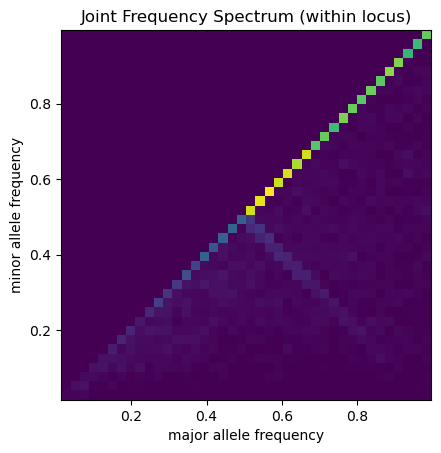

In [12]:
plt.clf()
plt.title('Joint Frequency Spectrum (within locus)')
plt.xlabel('major allele frequency')
plt.ylabel('minor allele frequency')
plt.axis('square')
plt.hist2d(df['f1'], df['f2'],bins=40)

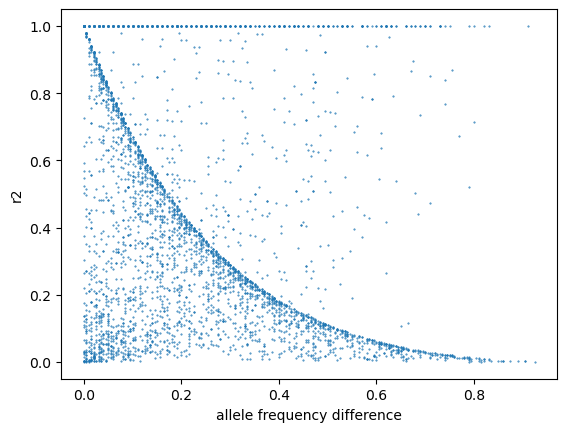

In [14]:
plt.clf()
plt.xlabel('allele frequency difference')
plt.ylabel('r2')
plt.scatter((df['f1']-df['f2']), df['r2'],s=0.2)
plt.savefig('r2_simplot.pdf')

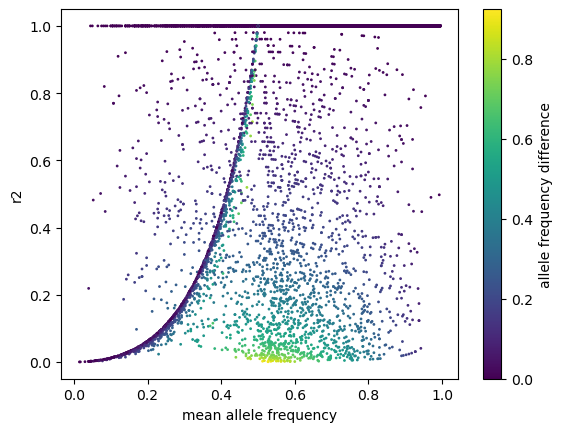

In [16]:
plt.clf()
plt.xlabel('mean allele frequency')
plt.ylabel('r2')
plt.scatter((df['f1']+df['f2'])/2, df['r2'],c=(df['f1']-df['f2']),s=1)
#plt.yscale('log')
plt.colorbar(label='allele frequency difference')
plt.savefig('r2_simplot_2.pdf')

Top line: two mutations occur on same branch in tree, so are occurring on the same haplotype only. Curve: not quadratic (check with log scale!) - not sure what's going on there yet. Maybe (inspired by https://www.sciencedirect.com/science/article/pii/S0040580908000609), this is the maximum $r^2$ between two alleles of that mean frequency, that are not on the same haplotype? I feel like this is a mixture of different configuration scenarios, and could be best explained via tree-based statistics. - note: it is different configuration scenarios! See R markdown.

Getting to a binned plot of r2 by frequency...

In [17]:
cuts = pd.DataFrame({str(feature) + 'Bin' : pd.cut(df['f1'], 10) for feature in ['f1','f2']})

cuts

,f1Bin,f2Bin
0,"(0.897, 0.995]","(0.897, 0.995]"
1,"(0.701, 0.799]","(0.701, 0.799]"
2,"(0.505, 0.603]","(0.505, 0.603]"
3,"(0.407, 0.505]","(0.407, 0.505]"
4,"(0.897, 0.995]","(0.897, 0.995]"
...,...,...
9428,"(0.701, 0.799]","(0.701, 0.799]"
9429,"(0.211, 0.309]","(0.211, 0.309]"
9430,"(0.799, 0.897]","(0.799, 0.897]"
9431,"(0.701, 0.799]","(0.701, 0.799]"


In [18]:
print(df.join(cuts))
means = df.join(cuts).groupby( list(cuts) )
means = means.mean()
means = means.unstack(level = 0) # Use level 0 to put 0Bin as columns.

# Reverse the order of the rows as the heatmap will print from top to bottom.
means = means.iloc[::-1]
print(means['r2'])

            r2     f1     f2           f1Bin           f2Bin
0     1.000000  0.960  0.960  (0.897, 0.995]  (0.897, 0.995]
1     1.000000  0.790  0.790  (0.701, 0.799]  (0.701, 0.799]
2     1.000000  0.570  0.430  (0.505, 0.603]  (0.505, 0.603]
3     0.394065  0.485  0.295  (0.407, 0.505]  (0.407, 0.505]
4     1.000000  0.905  0.905  (0.897, 0.995]  (0.897, 0.995]
...        ...    ...    ...             ...             ...
9428  1.000000  0.770  0.770  (0.701, 0.799]  (0.701, 0.799]
9429  1.000000  0.285  0.285  (0.211, 0.309]  (0.211, 0.309]
9430  0.123596  0.890  0.500  (0.799, 0.897]  (0.799, 0.897]
9431  1.000000  0.785  0.785  (0.701, 0.799]  (0.701, 0.799]
9432  1.000000  0.945  0.945  (0.897, 0.995]  (0.897, 0.995]

[9433 rows x 5 columns]
f1Bin           (0.014, 0.113]  (0.113, 0.211]  (0.211, 0.309]  \
f2Bin                                                            
(0.897, 0.995]             NaN             NaN             NaN   
(0.799, 0.897]             NaN             Na

<AxesSubplot: xlabel='f1Bin', ylabel='f2Bin'>

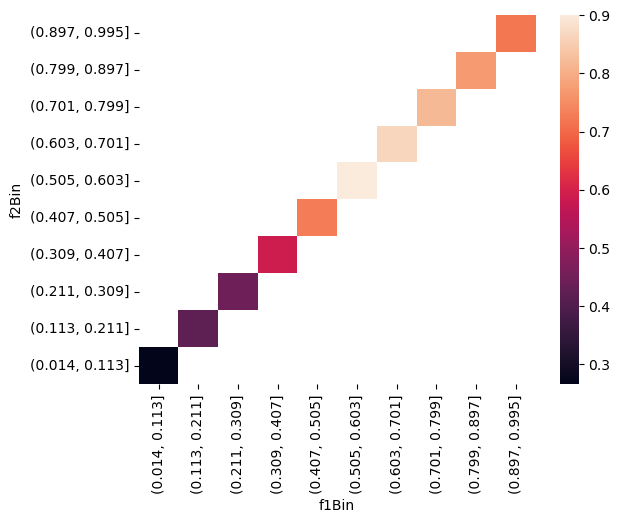

In [19]:
plt.clf()
sns.heatmap(means['r2']) 

Not really sure what is happening with this plot. I would do almost anything to tidyverse this instead. 

Next step: varying mutation rate. 

In [ ]:
mut_res = {}
for rate in [1e-9,5e-9,1e-8,5e-8,1e-7,5e-7]:
    print(f'mutation rate={rate}')
    rsm = sim_replicates(100,1000,mut_rate=rate)
    mut_res[rate]=rsm

mutation rate=1e-09
Failed 97.5% of attempts.
mutation rate=5e-09
Failed 67.4% of attempts.
mutation rate=1e-08
Failed 35.2% of attempts.
mutation rate=5e-08
Failed 2.1000000000000085% of attempts.
mutation rate=1e-07


In [ ]:
fig, axs = plt.subplots(3, 2, constrained_layout=True,figsize=(10, 10))

for ax, mr in zip(axs.flat, mut_res):
    dfm=mut_res[mr]
    ax.set_title(f'mutation rate={mr}')
    ax.set_xlabel('mean allele frequency')
    ax.set_ylabel('r2')
    ax.scatter((dfm['f1']+dfm['f2'])/2, dfm['r2'],c=(dfm['f1']-dfm['f2'])/(dfm['f1']+dfm['f2']),s=5)

In [ ]:
fig, axs = plt.subplots(3, 2, constrained_layout=True,figsize=(10, 10))

for ax, mr in zip(axs.flat, mut_res):
    dfm=mut_res[mr]
    ax.set_title(f'mutation rate={mr} \nJoint Frequency Spectrum \n(within locus)')
    ax.set_xlabel('major af')
    ax.set_ylabel('minor af')
    ax.hist2d(dfm['f1'], dfm['f2'],bins=25)

Why all this failing when we play with the mutation rate?

In [ ]:
mut_res = {}
for rate in [1e-9,1e-8,1e-5]:
    print(f'mutation rate={rate}')
    rsm = sim_replicates(100,1,mut_rate=rate,quiet=False)
    mut_res[rate]=rsm

mut_res

* When the mutation rate is too low, there simply are no mutations in the mutations table to report. This is a somewhat happy error (fix by adding a row with two zero frequency mutations?)
* When the mutation rate is too high, we get a tskit error. This error occurs when infinite sites is breached - specifically, the tskit LD calculations can't deal with more than one mutation happening at one site. Ways around this:
    * longer sequence. Not really a solution.
    * fewer individuals in population. Not really a solution. 
    * deal with LD in a different way when this happens, for example by directly computing the correlation between sites (maybe in the genotype matrix?). This will also let us see the sign of LD (currently not supported by the tskit LD calculator).

Getting LD via a haplotype matrix...

In [ ]:
nsamp=100
ts = msprime.sim_ancestry(
        samples=nsamp,
        population_size=10_000,
        sequence_length=1_000,
        recombination_rate=0)
# mutate
ts = msprime.sim_mutations(ts, rate=1e-06)
# get genotype matrix
g = np.array(ts.genotype_matrix())
#hs = ts.haplotypes()
#for h in hs:
#    print(np.array(h))
print(h.shape)
g

We have n rows (variable sites) by 200 columns (sample haplotypes). And yet! We have some '2' values in our matrix! How can this be?

In [ ]:
# compute allele frequency
afs=np.sum(g,axis=1)/(2*nsamp)
# print(afs) # by array
# print(allele_frequencies(ts).T) # by tskit
# sanity check- they agree
print(afs)
print(afs.shape)

In [ ]:
# compute cov
cv=np.cov(g)
# let's do an LD plot
plt.imshow(cv)

In [ ]:
top = np.argsort(afs)[::-1][:2]
print(afs[top])
# sanity check: dimensions
print(g[top,:].shape)
# sanity check: agrees with tskit?
print(np.cov(h[top,:])[0,1])
print(g[top,:]>1)
print(g[top,:])
r=get_row(ts)
print(r)
pos=ts.tables.sites.position
freqs=allele_frequencies(ts)
arr=np.column_stack((pos,freqs))
muts=pd.DataFrame(arr,columns=["position","frequency"])
muts=muts.sort_values(by='frequency', ascending=False)
print(muts)

This is baffling to me, why is the array 200 long (2xnumber of samples), yet we have the genotypes???

### Tree-based statistics

#### How many times is the minor mutation (node b) below the major mutation (node a)?
Let's define the major mutation as the most common mutation at a locus, and the minor as the second most common. In what proportion of trees is the minor one below the major one, as opposed to somewhere else in the tree?

To answer this, first we simulate a small locus, as above:

In [ ]:
nsamp=100
ts = msprime.sim_ancestry(
        samples=nsamp,
        population_size=10_000,
        sequence_length=1_000,
        recombination_rate=0, random_seed=4321)
# mutate
ts = msprime.sim_mutations(ts, rate=1e-07, random_seed=4321)

ts

In [ ]:
# make a dictionary of all the nodes below a given node
below={}
for tree in ts.trees():
    t=tree
    n_node=np.array(ts.tables.nodes).shape[0]
    for i in np.arange(0,n_node):
        below[i]=[u for u in t.nodes(i)]

ts.draw_svg(size=(1000,1000),y_axis=True)

In [ ]:
g = np.array(ts.genotype_matrix())
g.shape
afs=np.sum(g,axis=1)/(2*nsamp)
print(afs)
print(ts.tables.mutations)
print([u for u in t.nodes(396)])

The table shows the node above the mutation. So we want to extract the two most frequent mutations and their nodes, and check whether the mutation of node b is below that of node a.

Then - if the nodes are above/below each other, we can find the shared branch length as the difference in the mutation times. 

In [ ]:
nds=np.array([afs.T,ts.tables.mutations.node,ts.tables.mutations.time])
nds

In [ ]:
# get two most common mutations
top=np.argsort(afs.T)[::-1][:2]
print(top)
# indices
nds[:,top]

In [ ]:
# checking for nodes below
print(nds[1,top])
print(below[nds[1,top[0]]])
bl= nds[1,top[1]] in below[nds[1,top[0]]] # bl is the indicator for one mutation being below the next
tdiff=ts.tables.mutations.time[top][1]-ts.tables.mutations.time[top][0] 
shared_branch_length= tdiff* bl # shared branch length is indicator for below-ness times time difference

shared_branch_length

In [ ]:
# checking for nodes below- with two that actually are below
print(nds[1,[1,12]])
print(below[nds[1,top[1]]])
bl= nds[1,12] in below[nds[1,1]] 
print(ts.tables.mutations.time[12])
print(ts.tables.mutations.time[1])
tdiff=ts.tables.mutations.time[1]-ts.tables.mutations.time[12]
shared_branch_length= tdiff* bl

shared_branch_length

Now, I want to scale this up so that I can do it for all my simulation repeats. 